# Tarea 2. Clasificación de Animales. 
## Arnoldo Fernando Chue Sánchez

**Indicaciones**

Siguiendo el ejemplo de la libreta de flores, crea un clasificador de ANIMALES. Los datos vienen revueltos por lo que debemos realizar preprocesamiento

Primero cargamos las librerías que vamos a necesitar

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import splitfolders
import torch
import torch.nn
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
import PIL

Lo primero que debemos hacer es armar los conjuntos de entrenamiento y validación. Sin embargo, nuestras imágenes no están etiquetadas: vienen con un nombre genérico que no tiene información del nombre de los animales. Esa información viene en un dataset por separado. En pocas palabras, las imágenes no tienen etiquetas, éstas últimas vienen en un archivo por separado. Así que para armar las carpetas con las etiquetas vamos a realizar lo siguiente:

In [3]:
# Leemos el dataset
df1 = pd.read_csv("AnimalsSmall/train.csv")
df1.head(15)

,Image_id,Animal
0,Img-1.jpg,hippopotamus
1,Img-2.jpg,squirrel
2,Img-3.jpg,grizzly+bear
3,Img-4.jpg,ox
4,Img-5.jpg,german+shepherd
5,Img-6.jpg,buffalo
6,Img-7.jpg,otter
7,Img-8.jpg,bobcat
8,Img-9.jpg,wolf
9,Img-10.jpg,persian+cat


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  13000 non-null  object
 1   Animal    13000 non-null  object
dtypes: object(2)
memory usage: 203.3+ KB


Tenemos las 13k imágenes con su etiqueta. Veamos cuántas etiquetas son:

In [6]:
df1["Animal"].value_counts()

Animal
horse              1111
squirrel            808
antelope            695
german+shepherd     687
collie              680
seal                665
buffalo             606
grizzly+bear        583
otter               519
ox                  501
persian+cat         491
chimpanzee          477
rhinoceros          477
moose               476
hippopotamus        464
bobcat              418
wolf                403
chihuahua           386
dalmatian           359
raccoon             346
siamese+cat         341
bat                 256
rat                 220
killer+whale        193
spider+monkey       189
weasel              184
walrus              148
beaver              133
mouse               124
mole                 60
Name: count, dtype: int64

Tenemos 30 tipos de animales diferentes. Las categorías no están balanceadas, por lo que es un factor importante a tomar en cuenta.

De este modo lo que sigue es hacer un folder general de animales por categoría. Dentro de esa carpeta estarán otras carpetas, cada una por las 30 etiquetas.

In [8]:
os.makedirs("AnimalesCategorias", exist_ok=True)
for titulo in df1["Animal"].values: 
    titulo = titulo.replace("+", " ")
    os.makedirs("AnimalesCategorias/" + titulo, exist_ok=True)
    

In [9]:
os.listdir("AnimalesCategorias")

['antelope',
 'bat',
 'beaver',
 'bobcat',
 'buffalo',
 'chihuahua',
 'chimpanzee',
 'collie',
 'dalmatian',
 'german shepherd',
 'grizzly bear',
 'hippopotamus',
 'horse',
 'killer whale',
 'mole',
 'moose',
 'mouse',
 'otter',
 'ox',
 'persian cat',
 'raccoon',
 'rat',
 'rhinoceros',
 'seal',
 'siamese cat',
 'spider monkey',
 'squirrel',
 'walrus',
 'weasel',
 'wolf']

Ahora lo que tenemos que hacer es pasar o copiar las imágenes

In [15]:
for i in range(13000):
    img, label = df1.iloc[i, 0], df1.iloc[i, 1]
    label = label.replace("+", " ")
    shutil.copyfile("AnimalsSmall/images/" + img, "AnimalesCategorias/" + label + "/" + img)

Finalmente podemos generar los conjuntos de entrenamiento y validación. Para eso usaré la librería split-folders que justo hace esa tarea. Los porcentajes que usaré son 70% entrenamiento y 30% prueba

In [16]:
splitfolders.ratio(input="AnimalesCategorias", output="AnimalesTrainVal1",
                    seed=2006, ratio=(0.7, 0.3), group_prefix=None, move=False)

Copying files: 13000 files [00:15, 825.22 files/s]


Con esto ya podemos usar nuestra función para cargar los datos, formar los batch y hacer el data augmentation

In [2]:
def load_data(folder, img_size, batch_size):
    # Dejaremos las mismas transformaciones que la clase
    tfms = fv.aug_transforms(flip_vert=False, # aquí quitamos esta transformación porque voltear animales de cabeza más que ayudar va a perjudicar a la red
                             max_rotate=90, # reducimos la rotación para no ver los animales de cabeza
                             max_lighting=0.25,
                             max_zoom=1.2,
                             max_warp=0.2)
    
    # dado que formamos la carpeta de imágenes igual a la que usamos en clase también podemos reutilizar la construcción del datablock
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms
                        )
    
    return data.dataloaders(folder, batch_size=batch_size)

Cargamos los datos

In [3]:
data = load_data("AnimalesTrainVal1", img_size=256, batch_size=64) # dejamos estas medidas provisionales esperando que no nos de error de memoria

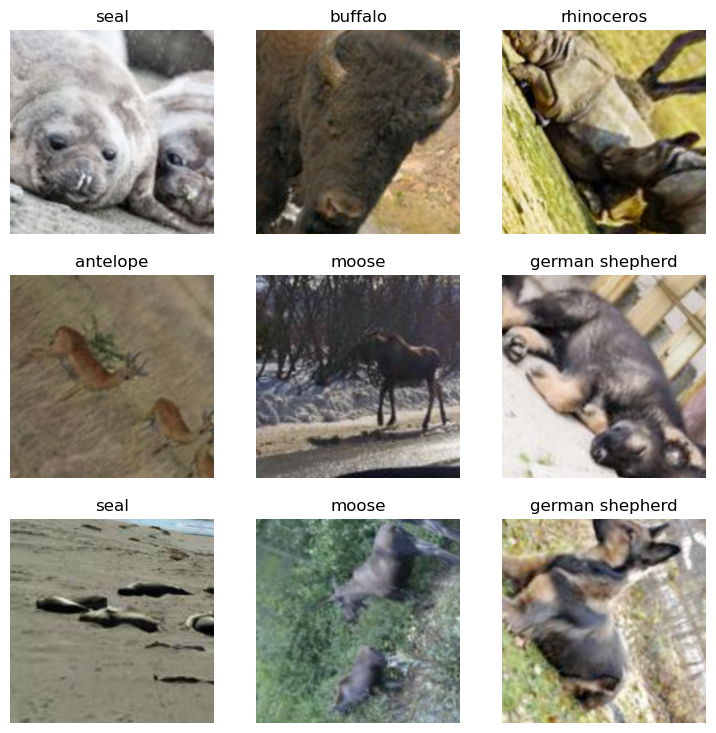

In [10]:
data.show_batch()

Vamos a crear nuestro learner. Para este primer experimento justo vamos a usar la arquitectura convolucional de resnet18 con ranger

In [4]:
learn = fv.vision_learner(dls=data,
                          arch=fv.resnet18,
                          metrics=fv.accuracy,
                          opt_func=fv.ranger)

Busquemos el mejor valor para nuestra tasa de aprendizaje

c:\Users\Fernando\anaconda3\envs\redes\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **

SuggestedLRs(valley=0.0030199517495930195)

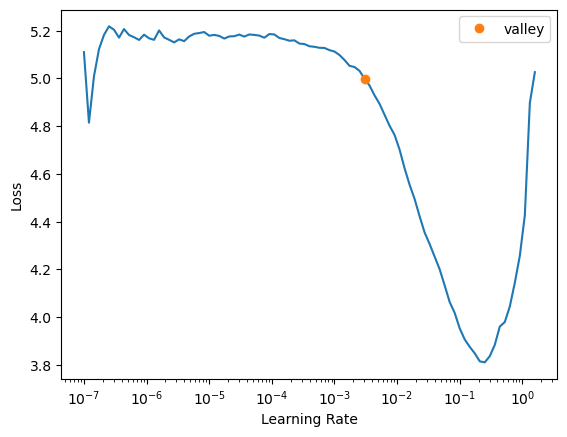

In [5]:
learn.lr_find()

Vamos a tomar un learning rate de 0.02, 10 épocas y usaremos el fit_one_cycle con los parámetros para Ranger (solamente ajustaremos el pct_start a 0.75 para que comience a reducir la tasa de aprendizaje más pronto)

In [6]:
learn.fit_one_cycle(10, 0.02, div=1, pct_start=0.75)

epoch,train_loss,valid_loss,accuracy,time
0,1.447617,None,None,01:25
1,1.282556,None,None,01:20
2,1.203190,None,None,01:21


c:\Users\Fernando\anaconda3\envs\redes\Lib\site-packages\fastprogress\fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


KeyboardInterrupt: 

Como vemos la red no está aprendiendo, por lo que hay que comenzar a debuguear (parece que hay problemas al cargar nuestros datos)

In [7]:
learn.dls.valid.items

[]

In [9]:
len(learn.dls.train)

141

In [10]:
len(learn.dls.valid)

0

El problema está en que no estamos cargando el conjunto de validación. Por eso la red sí reducía la función de pérdida, pero no mostraba nada al momento de validar los pesos con el conjunto de validación. Esto podría ser porque splitfolders nos genera dentro de la carpeta AnimalesTrainVal1 la carpeta val. Sin embargo, en la función de load_data (al usar la estructura de carpetas de parents y grandparent) espera el nombre valid

In [11]:
os.rename("AnimalesTrainVal1/val", "AnimalesTrainVal1/valid")

Volvemos a cargar los datos

In [12]:
data = load_data("AnimalesTrainVal1", img_size=256, batch_size=64)

Creamos el learner

In [13]:
learn = fv.vision_learner(dls=data,
                          arch=fv.resnet18,
                          metrics=fv.accuracy,
                          opt_func=fv.ranger)

Volvemos a buscar el learning rate

c:\Users\Fernando\anaconda3\envs\redes\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **

SuggestedLRs(valley=0.004365158267319202)

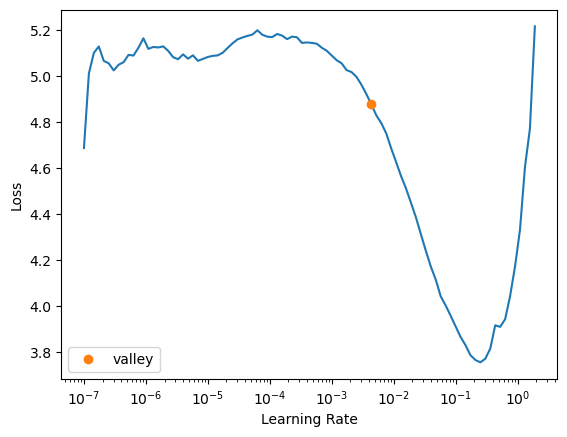

In [14]:
learn.lr_find()

Y volvemos al proceso de entrenamiento con un learning rate de 0.05

In [15]:
learn.fit_one_cycle(10, 0.05, div=1, pct_start=0.75)

epoch,train_loss,valid_loss,accuracy,time
0,1.899831,1.634986,0.605774,01:42
1,1.434116,0.831251,0.748595,01:22
2,1.384836,1.166852,0.654318,01:21
3,1.428243,0.857530,0.743485,01:22
4,1.407088,1.999595,0.551610,01:22
5,1.415819,0.891190,0.736842,01:27
6,1.420383,1.277143,0.630046,01:31
7,1.339749,0.765707,0.764946,01:34
8,1.051970,0.589845,0.816045,01:32
9,0.830657,0.513908,0.846960,01:30


Aquí podemos hacer una observación interesante: durante las primeras 7 épocas el accuracy cambió del 75% al 60% aproximadamente, alternando entre cada época. Esto podríamos explicarlo con una tasa de aprendizaje demasiado grande durante esas épocas. Precisamente, al darle un pct_start del 0.75 indicamos que hasta ese momento vamos a comenzar a reducir la tasa de aprendizaje. Por lo tanto vamos a repetir las 10 épocas con el mismo modelo, pero vamos a mantener ahora una tasa de aprendizaje más pequeña y la dejaremos fija para las 10 épocas

In [29]:
learn = fv.vision_learner(dls=data,
                          arch=fv.resnet18,
                          metrics=fv.accuracy,
                          opt_func=fv.ranger)

SuggestedLRs(valley=0.00363078061491251)

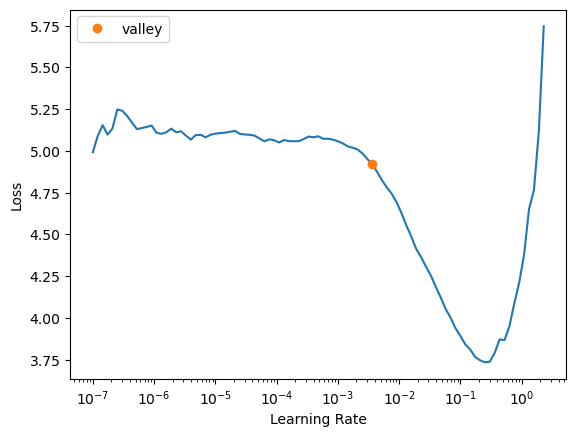

In [30]:
learn.lr_find()

In [31]:
learn.fit(10, 9e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.419527,0.581340,0.821666,01:26
1,1.090042,0.540121,0.838784,01:27
2,1.002537,0.584525,0.819366,01:26
3,0.980311,0.527272,0.834696,01:29
4,0.937897,0.556289,0.824732,01:28
5,0.903063,0.502890,0.842616,01:32
6,0.855360,0.562550,0.829586,01:27
7,0.803798,0.486802,0.851814,01:31
8,0.788794,0.532598,0.838273,01:26
9,0.799142,0.484880,0.846704,01:26


Este entrenamiento resultó mucho mejor, aunque algo lenta la mejora entre cada época. Con algunas épocas más podríamos alcanzar a superar el 90% de accuracy.

In [32]:
learn.fit(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.773944,0.498164,0.845682,01:21
1,0.774268,0.476415,0.846704,01:21
2,0.736106,0.472940,0.851048,01:20
3,0.735948,0.471552,0.852580,01:20
4,0.695319,0.466604,0.859223,01:22
5,0.707384,0.483610,0.851303,01:23
6,0.696118,0.481804,0.846960,01:24
7,0.708886,0.455966,0.857435,01:22
8,0.679761,0.429882,0.863311,01:22
9,0.662208,0.453299,0.862545,01:24


Como podemos ver el entrenamiento funciona, pero se algo lento por la tasa de aprendizaje. Por ahora como el objetivo de la tarea era aplicar lo que vimos con el conjunto de flores, pero con animales vamos a dejarlo hasta aquí (porque si cambiamos bruscamente la tasa de aprendizaje para más épocas podemos romper el modelo)

Lo que sí podemos hacer es mostrar algunas predicciones

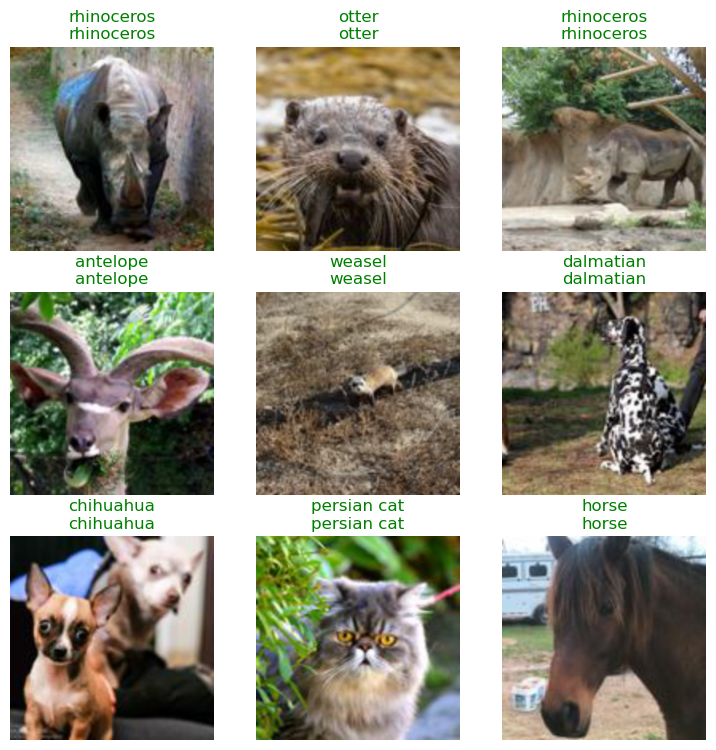

In [33]:
learn.show_results()

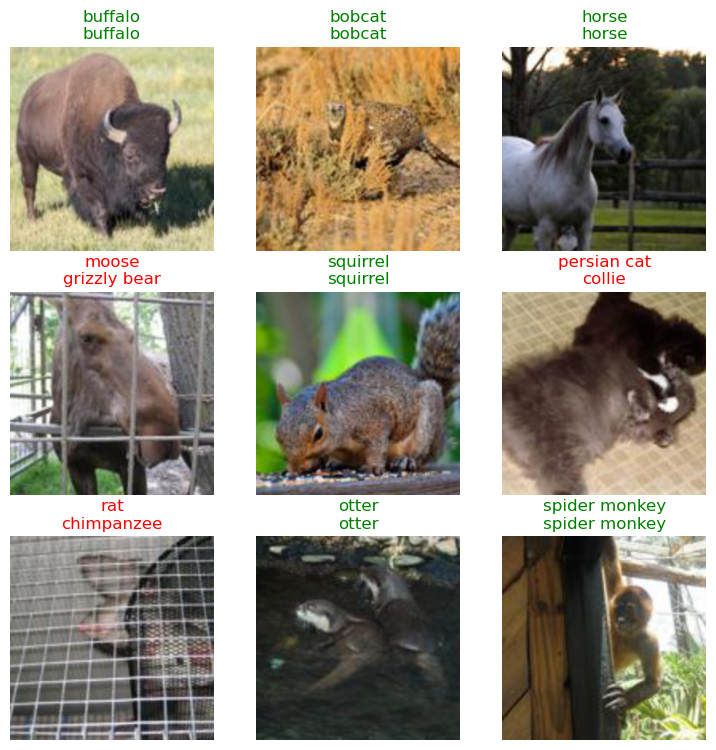

In [36]:
learn.show_results()